In [12]:
import pro_gan_pytorch.PRO_GAN as pg
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import torch
import torchvision
import csgm
import dcgan
import skimage
import anchor_image
import image_utils
import celeba_utils
import torch
import torch.nn
from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

def np_dim_ran(x):
    print(x.shape, np.min(x), np.max(x))
def torch_dim_ran(x):
    print(x.shape, torch.min(x), torch.max(x))

# from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample, save_as_images)
import torchvision.models as models
from sklearn.preprocessing import normalize

## Setup Device and ProGAN

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
gen = torch.nn.DataParallel(pg.Generator(depth=9))

In [7]:
gen.load_state_dict(torch.load("GAN_GEN_SHADOW_8.pth", map_location=str(device)))

In [10]:
gen.train();

## Load first 50 images from ./examples/

In [11]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('./examples/*.jpg'): #assuming gif
    im=Image.open(filename)
    image_list.append(np.array(im))
    im.close()
    if(len(image_list) > 50):
        break

# Select Image and Prepare for Anchors

In [15]:
import cv2
t_image = image_list[7][:1024][:1024]

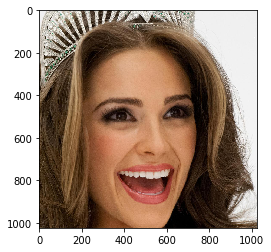

In [16]:
plt.imshow(t_image)

In [17]:
t_image = cv2.resize(t_image, (256,256))
t_image = t_image/255.
target = t_image


## Init Explainer (Anchor) and Classifier (Model)

In [18]:
explainer = anchor_image.AnchorImageCeleb([], 'yeet', G=gen, dataset = [], threshold=.1)

In [20]:
import class_models

model = class_models.celebAModel((3,256,256),device='cpu')
model.load_state_dict(state_dict=torch.load('pretrained_celeba_smiling_4.pt'))
model.eval();

In [21]:
def predict_fn(images):
    try:
        images = torch.from_numpy(images).type(torch.FloatTensor)
    except:
        pass
    return model(images.view(images.shape[0],3,256,256)).data.numpy()

# FIND ANCHOR

In [22]:
segments, exp  = explainer.explain_instance(t_image,predict_fn,verbose=True)

True pred 0
[]
(256, 256, 3)
0.0 0.0
1e-09
0.1
Anchor takes:  0.0 % of image pixels
DONE SAMPLING
[]
(256, 256, 3)
0.0 0.0
1e-09
0.1
Anchor takes:  0.0 % of image pixels
DONE SAMPLING
0.0 0.0
1e-09
0.1
Anchor takes:  0.0 % of image pixels
DONE SAMPLING
[0]
(256, 256, 3)
-1.0 1.0
91683.000000001
0.1
Anchor takes:  46.0 % of image pixels
DONE SAMPLING
[1]
(256, 256, 3)
-1.0 0.7568627450980392
25158.000000001
0.1
Anchor takes:  12.0 % of image pixels
DONE SAMPLING
[2]
(256, 256, 3)
-0.9215686274509804 0.8352941176470587
40683.000000001
0.1
Anchor takes:  20.0 % of image pixels
DONE SAMPLING
[3]
(256, 256, 3)
-1.0 0.7647058823529411
25482.000000001
0.1
Anchor takes:  12.0 % of image pixels
DONE SAMPLING
[4]
(256, 256, 3)
-1.0 0.8666666666666667
13602.000000001
0.1
Anchor takes:  6.0 % of image pixels
DONE SAMPLING
Best: 4 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 0 (mean:1.0000, n: 1, ub:1.0000) B = 1.00
[0]
(256, 256, 3)
-1.0 1.0
91683.000000001
0.1
Anchor takes:  46.0 % of image pixels

KeyboardInterrupt: 

### Exp_[feature] isn't working great in create_mask, so just hardcode the printed out result 

In [ ]:
print(exp)

In [ ]:
exp_ = {'feature':[4]}
_, anchor_mask = image_utils.create_mask(t_image,segments,exp_,rgb=True)

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(28,28))
ax[0].imshow(anchor_mask*t_image + (1-anchor_mask)*np.ones(shape=(256,256,3))) # anchor and make background white
ax[0].axis('off')
ax[1].imshow(t_image)
ax[1].axis('off')